In [79]:
from PIL import Image
from PIL import ImageStat
from PIL import ImageDraw
from PIL import ImageFilter
import copy
import numpy as np
import math
import random

In [80]:
im = Image.open("NewYork.jpg").convert('L')
width, height = im.size
print((width, height))

(1300, 1300)


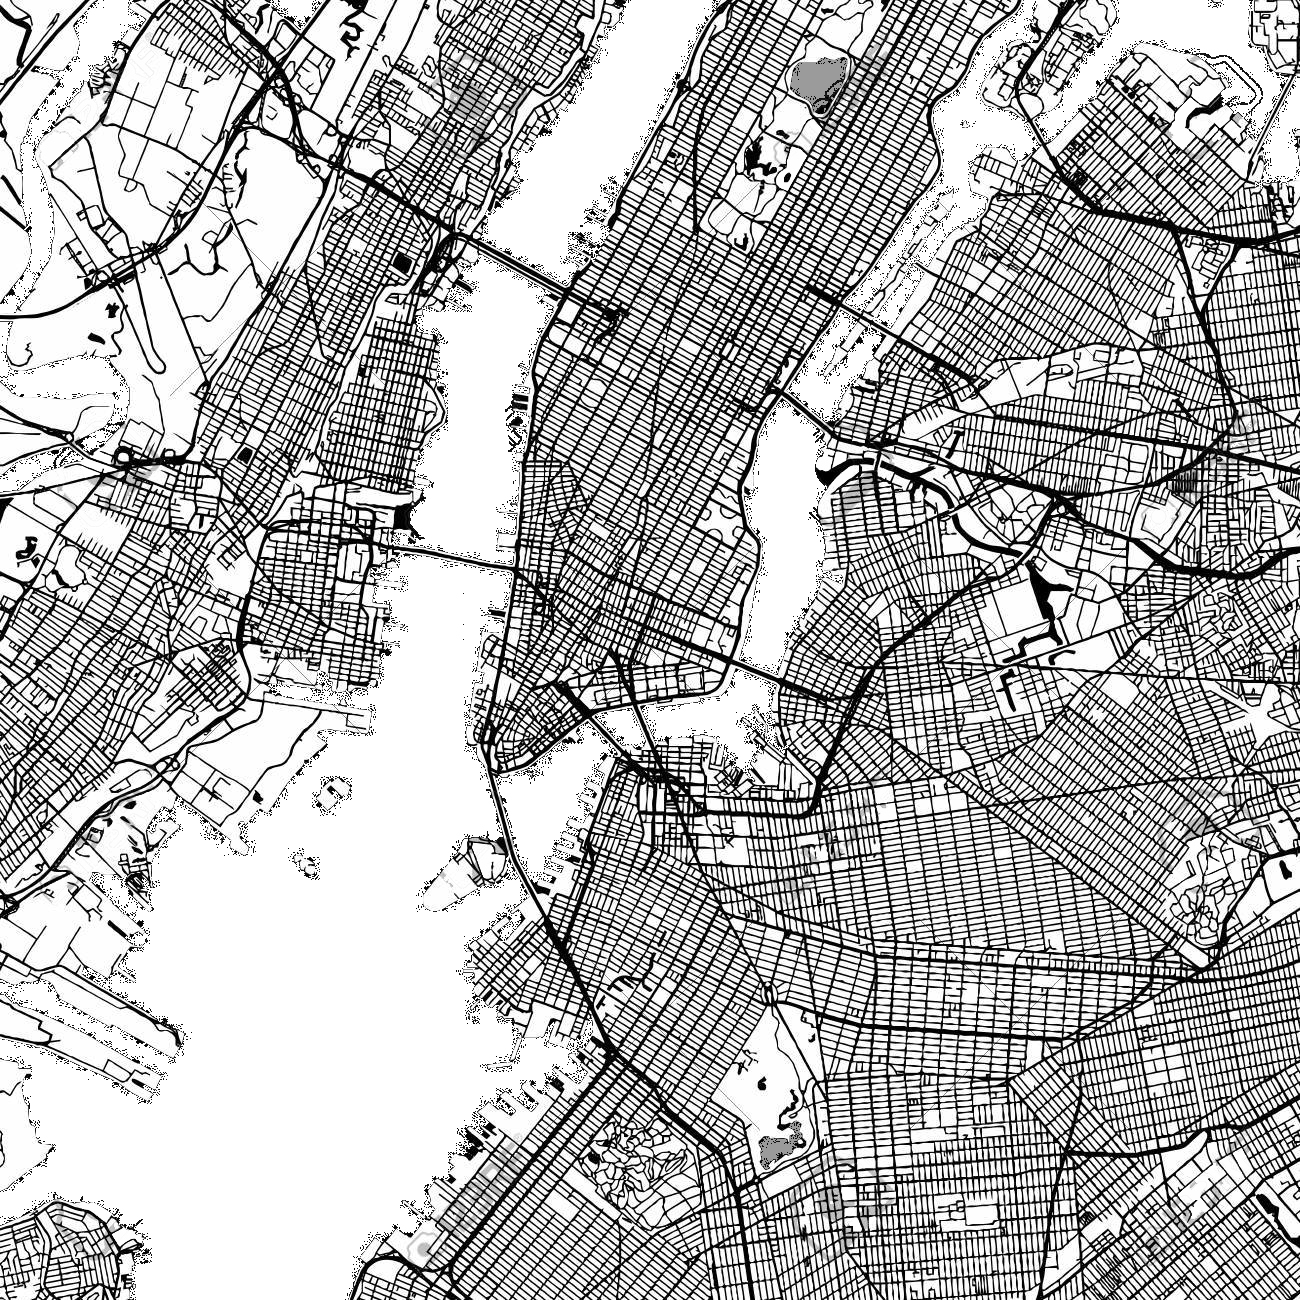

In [81]:
im

In [82]:
print("preparing image scale pyramid...")
sigma = 1
im0 = im. filter(ImageFilter.GaussianBlur(sigma))
im1 = im0.filter(ImageFilter.GaussianBlur(2*sigma))
im2 = im1.filter(ImageFilter.GaussianBlur(4*sigma))
im3 = im2.filter(ImageFilter.GaussianBlur(8*sigma))

preparing image scale pyramid...


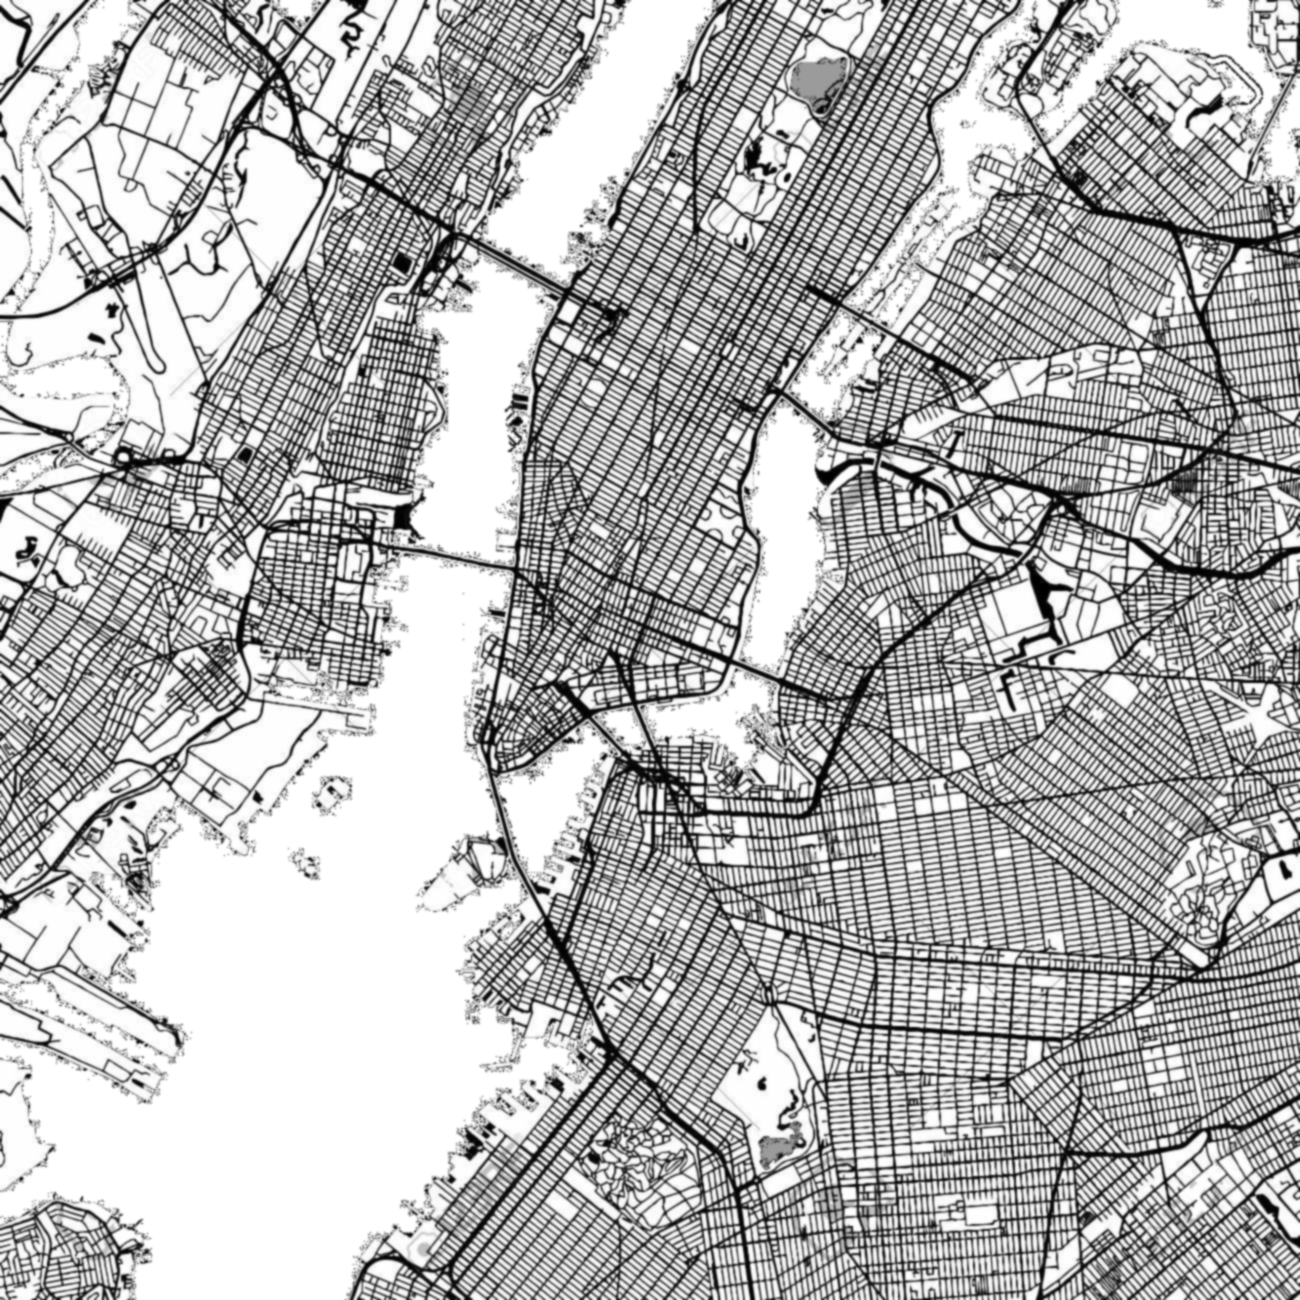

In [83]:
im0

In [84]:
phi = (1 + 5 ** 0.5)/2.0
# http://www.ams.org/journals/mcom/1999-68-225/S0025-5718-99-00996-5/S0025-5718-99-00996-5.pdf
sq2 = 0.5545497 #math.fmod(2 ** 0.5,1)
sq3 = 0.308517 #math.fmod(3 ** 0.5,1)
def goldenseq1(i, seed=0):
    return math.fmod(seed+i*sq2,1)

def goldenseq2(i, seed=0):
    return math.fmod(seed+i*sq3,1)

def compact1By2(x):
    x &= 0x09249249;                  # x = ---- 9--8 --7- -6-- 5--4 --3- -2-- 1--0
    x = (x ^ (x >>  2)) & 0x030c30c3 # x = ---- --98 ---- 76-- --54 ---- 32-- --10
    x = (x ^ (x >>  4)) & 0x0300f00f # x = ---- --98 ---- ---- 7654 ---- ---- 3210
    x = (x ^ (x >>  8)) & 0xff0000ff # x = ---- --98 ---- ---- ---- ---- 7654 3210
    x = (x ^ (x >> 16)) & 0x000003ff # x = ---- ---- ---- ---- ---- --98 7654 3210
    return x

def decodeMorton2X(code):
    return compact1By2(code >> 0)

def decodeMorton2Y(code):
    return compact1By2(code >> 1)


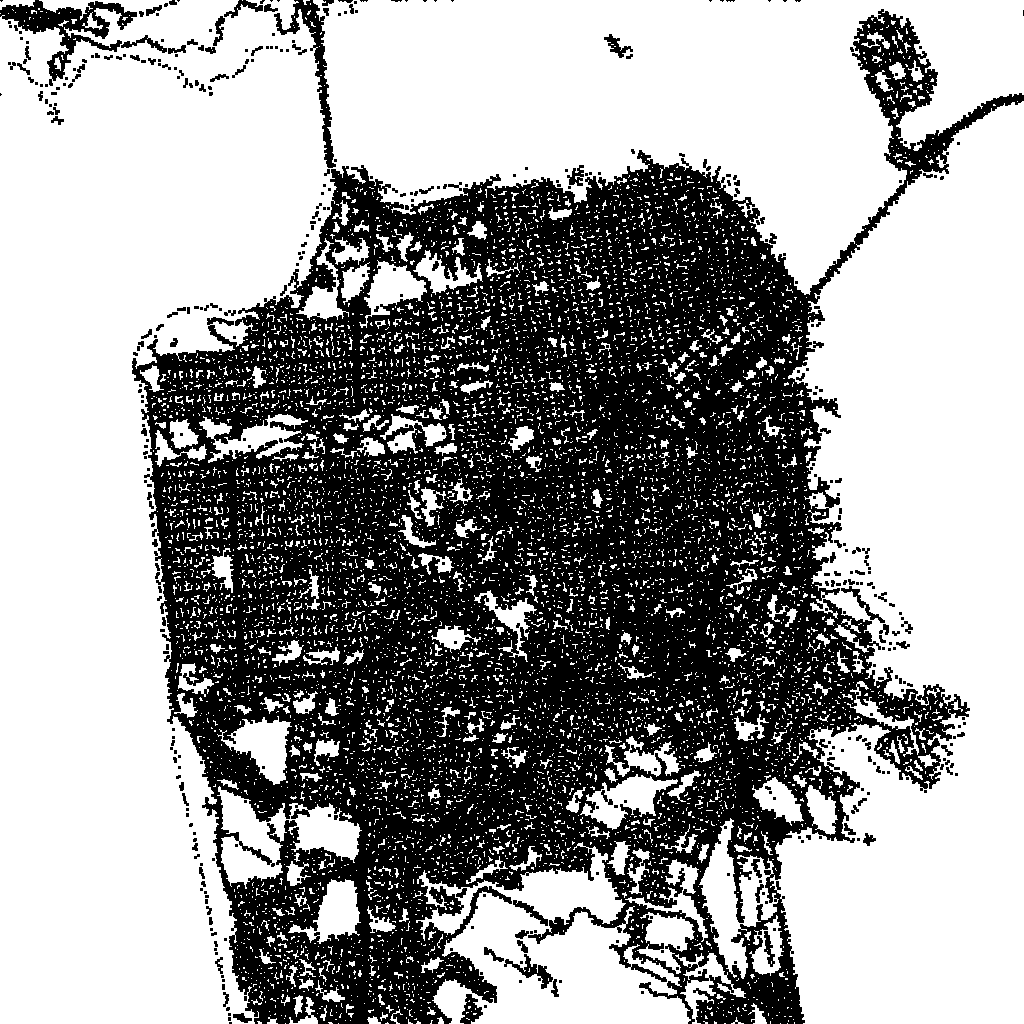

In [42]:
imd = copy.deepcopy(im)
draw = ImageDraw.Draw(imd)
draw.rectangle([(0,0), (width,height)], fill=(255))

n = 600000 
radius = 1
jitter = 1.5 #radius/2
      
for i in range(0, n, 1):
        x = goldenseq1(i)*width + jitter*random.uniform(-1,1)
        y = goldenseq2(i)*height + jitter*random.uniform(-1,1)
            #print((x,y))
        
        #if (float(i)/n) < (float(y)/height):
        if (float(i)/n) < 1-(im0.getpixel((x%width, y%height))/255.0):
            draw.ellipse([(x-radius,y-radius), (x+radius,y+radius)], fill=(0))
        
imd

In [85]:
n= 600000
ithreshold = 0.05
jitter = 1
delta  = 2*sigma

maxdim = max(width,height)

xstart  = 0
xstop   = width
ystart  = 0
ystop   = height

#xstart  = int(width*0.40)
#xstop   = int(width*0.60)
#ystart  = int(height*0.8)
#ystop   = int(height*0.2)

xa= np.empty([n])
ya= np.empty([n])
ra= np.empty([n])
dxa= np.empty([n])
dya= np.empty([n])
ia = np.empty([n])

print("analysing image...")
i=0
for i in range(0, n, 1):
    if i%10000==0:
        print('.', end='')
        
    x = goldenseq1(i)*width  + jitter*random.uniform(-1,1)
    y = goldenseq2(i)*height + jitter*random.uniform(-1,1)
    
    x = 0 if x<0 else x
    y = 0 if y<0 else y
    x = width-1 if x>=width else x
    y = height-1 if y>=height else y
    
    if x<xstart or x>xstop or y<ystart or y>ystop: 
        continue
        
    intensity = 1-(im0.getpixel((x, y))/256.0)
    
    rescaled_intensity = (intensity-ithreshold)/(1.0-ithreshold)

    if rescaled_intensity>=0 and (float(i)/n)<rescaled_intensity:
        xa[i]=x
        ya[i]=y

        dx=0
        dy=0

        try:
            dx = (im0.getpixel((x+delta, y))-im0.getpixel((x-delta, y)))/256.0
            dy = (im0.getpixel((x, y+delta))-im0.getpixel((x, y-delta)))/256.0

            dx += 0.5*(im1.getpixel((x+2*delta, y))-im1.getpixel((x-2*delta, y)))/256.0
            dy += 0.5*(im1.getpixel((x, y+2*delta))-im1.getpixel((x, y-2*delta)))/256.0

            dx += 0.25*(im2.getpixel((x+4*delta, y))-im2.getpixel((x-4*delta, y)))/256.0
            dy += 0.25*(im2.getpixel((x, y+4*delta))-im2.getpixel((x, y-4*delta)))/256.0

            dx += 0.125*(im3.getpixel((x+8*delta, y))-im3.getpixel((x-8*delta, y)))/256.0
            dy += 0.125*(im3.getpixel((x, y+8*delta))-im3.getpixel((x, y-8*delta)))/256.0               
        except IndexError:
            dx=0
            dy=0

        length = math.hypot(dx,dy)

        if abs(length)>0.001:     
            dxa[i]=dx/length
            dya[i]=dy/length
        else:
            dxa[i]=0
            dya[i]=0

        ia[i] = rescaled_intensity

        i=i+1
        #print((x,y,i))
print("done!")

analysing image...
............................................................done!


preparing drawing image...
drawing image... at least 599999 objects to draw! 
............................................................done!
(599999, 599999)


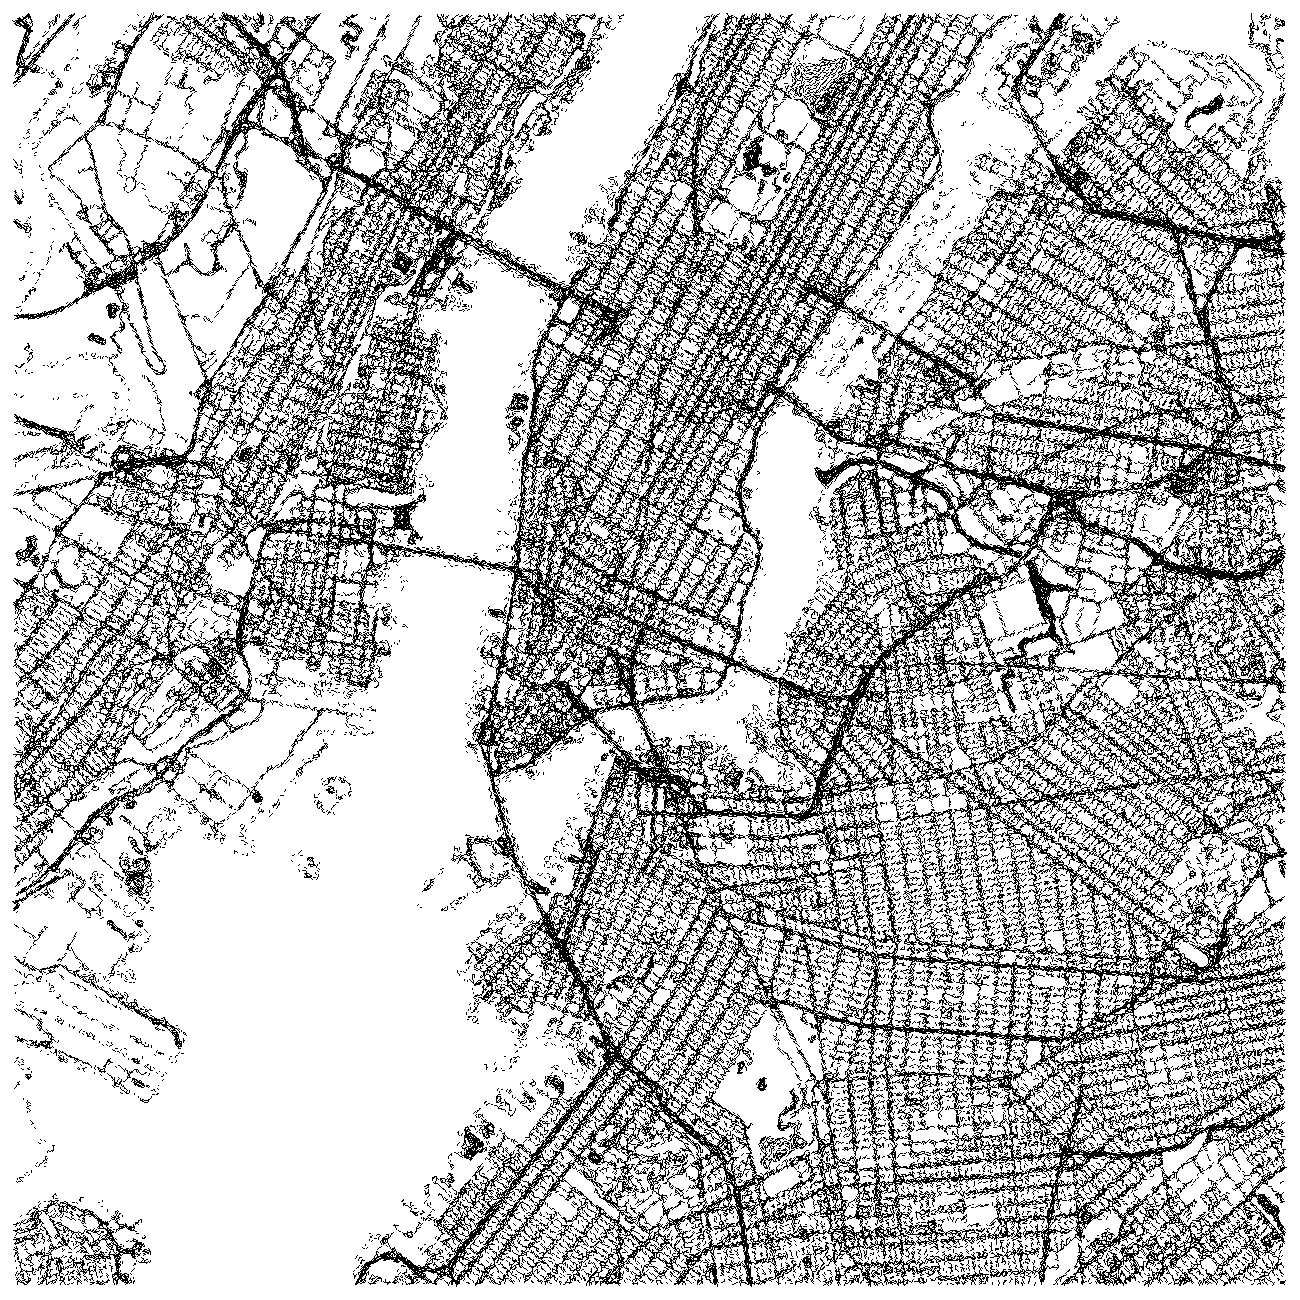

In [92]:
lthreshold = 0.9
length_param = 3

print("preparing drawing image...")
imd = copy.deepcopy(im)
draw = ImageDraw.Draw(imd)
draw.rectangle([(0,0), (width,height)], fill=(255))

line_list=[]
n=i 
print("drawing image... at least %d objects to draw! " % n)
for j in range(0,n,1):
    if j%10000==0:
        print('.', end='')

    intensity = ia[j]
    strength = length_param*intensity 
    dx     = dxa[j]*strength
    dy     = dya[j]*strength
    
    length = 2*math.hypot(dx,dy)

    if length>=lthreshold:
        x      = xa[j]
        y      = ya[j]
        #gradrect = [(x-dx,y-dy), (x+dx,y+dy)]
        rotrect  = [(x-dy,y+dx), (x+dy,y-dx)]
        draw.line(rotrect)

        line = [((x-dy)/maxdim,(y+dx)/maxdim), ((x+dy)/maxdim,(y-dx)/maxdim)]
        line_list.append(line)
print("done!")
print((n,i))    
imd 

In [93]:
def morton(x, y):
    x = (x | (x << 16)) & 0x0000FFFF0000FFFF;
    x = (x | (x << 8))  & 0x00FF00FF00FF00FF;
    x = (x | (x << 4))  & 0x0F0F0F0F0F0F0F0F;
    x = (x | (x << 2))  & 0x3333333333333333;
    x = (x | (x << 1))  & 0x5555555555555555;

    y = (y | (y << 16)) & 0x0000FFFF0000FFFF;
    y = (y | (y << 8))  & 0x00FF00FF00FF00FF;
    y = (y | (y << 4))  & 0x0F0F0F0F0F0F0F0F;
    y = (y | (y << 2))  & 0x3333333333333333;
    y = (y | (y << 1))  & 0x5555555555555555;

    return x | (y << 1);

def sortmorton(x):
    [(ax,ay), (bx,by)] = x
    return morton(int(4096*(ax+bx)),int(4096*(ay+by)))

def sortlength(x):
    [(ax,ay), (bx,by)] = x
    return abs(ax-bx)+abs(ay-by)


line_list.sort(key=lambda x: sortmorton(x) , reverse=True)

print(len(line_list))

149550


In [94]:
%%capture 
%run ../xyplotter.py

In [95]:
plotter = XYPlotter()
plotter.connect()

/dev/ttyUSB0


In [96]:
plotter.gotozero()
plotter.penoff()
len(line_list)

149550

In [97]:
pw = 30.5
ph = 30.5

w  = 20
h  = 20

x0 = (pw-w)/2 
y0 = (ph-h)/2

if width>height:
    y0 += h*(1-float(height/width))/2
elif height>width:
    x0 += w*(1-float(width/height))/2 

print(width,height)  
print((1-width/height)/2) 
print(w*(1-width/height)/2 ) 
print(x0,y0)    

1300 1300
0.0
0.0
5.25 5.25


In [19]:
#plotter.gotozero()
#plotter.rectangle(x0,y0,w*float(width/maxdim),h*float(height/maxdim))

In [ ]:
speed = 500
plotter.gotozero()
for line in line_list:
    [(nax,nay),(nbx,nby)] = line
    ax = x0+w*nax
    ay = y0+h*(1-nay)
    bx = x0+w*nbx
    by = y0+h*(1-nby)
    
    #print(line)
    #print("%f %f %f %f" % (ax, ay, bx, by))
    plotter.line(ax, ay, bx, by, speed)
    #plotter.line(bx, by, ax, ay, speed)
    
plotter.gotozero()      
plotter.penoff()